In [1]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm



In [2]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

In [4]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '1')

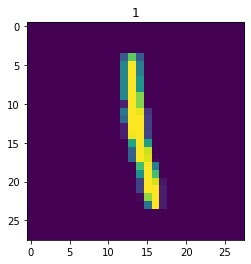

In [5]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

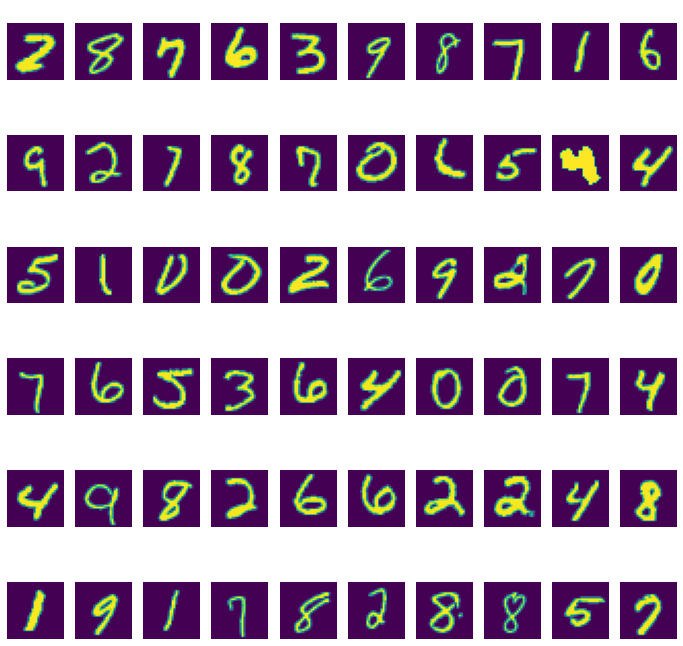

In [6]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

In [7]:
# num_splits=2

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [8]:
# Model Architecture

dropout_value = 0.05
num_splits=2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
           nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
             ReLU-10           [-1, 16, 22, 22]               0
   GhostBatchNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [9]:
# Train Function

# Train and Test Functuions
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)



In [10]:
# Test Function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:


# Train the model with lr scheduler. 

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)


EPOCHS = 15
for epoch in range(EPOCHS):
    
    print("EPOCH:", epoch)
    print('learning rate ', scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()    
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.0701456144452095 Batch_id=468 Accuracy=92.17: 100%|██████████| 469/469 [00:10<00:00, 44.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9831/10000 (98.31%)

EPOCH: 1
learning rate  [0.01]


Loss=0.02553693950176239 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9892/10000 (98.92%)

EPOCH: 2
learning rate  [0.01]


Loss=0.04016878083348274 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9893/10000 (98.93%)

EPOCH: 3
learning rate  [0.01]


Loss=0.024317936971783638 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 43.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 4
learning rate  [0.01]


Loss=0.04757952690124512 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9921/10000 (99.21%)

EPOCH: 5
learning rate  [0.01]


Loss=0.09607729315757751 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.10%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.007274985779076815 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 43.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.008743722923099995 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.004470231477171183 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.010618737898766994 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 43.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.01945793628692627 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.012791868299245834 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 43.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.005439616274088621 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.011628610081970692 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 43.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.011665706522762775 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 43.66it/s]



Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)



In [12]:
# Save the model

Text(0.5, 1.0, 'Test Accuracy')

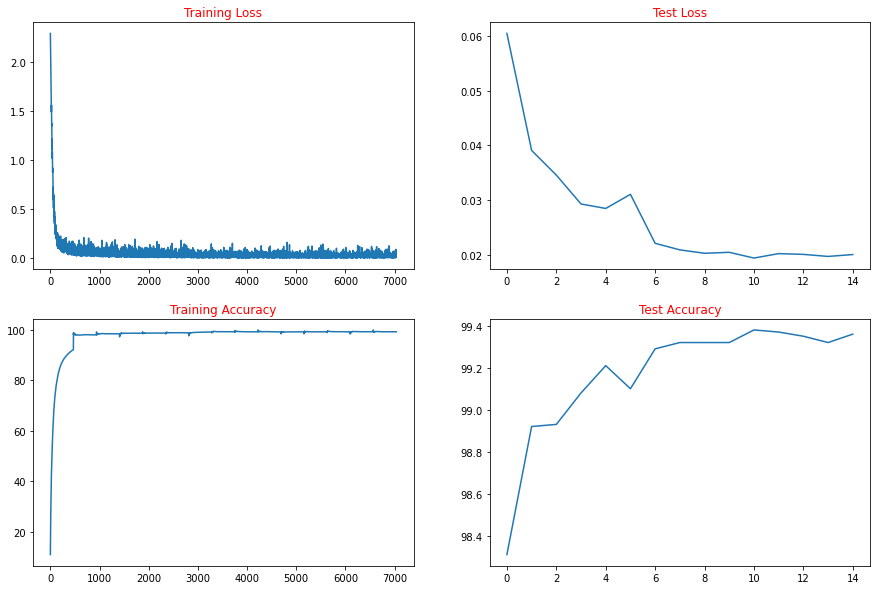

In [13]:
# Plot Error and accuracy
# Plot the accuracy and loss curves. 
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss",color='r')
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy",color='r')
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss",color='r')
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy", color='r')

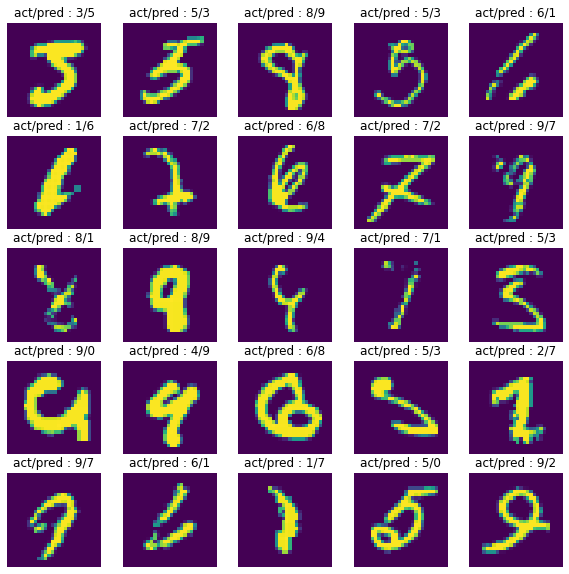

In [14]:
# Visualize the misclassified images
model.eval()

figure = plt.figure(figsize=(10,10))
num_of_images = 25
index=1


with torch.no_grad():
  for data,target in test_loader:
    data,target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1,keepdim=True)
    act = target.view_as(pred)
    bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

    # now extract the index number from the tensor which has 'true' 
    idx = list(np.where(bool_vec.cpu().numpy())[0])

    if idx: # if not a blank list
      idx_list = idx
      # print(data[idx_list[0]].shape)
      if index < num_of_images+1:
            
          plt.subplot(5,5,index)
          plt.axis('off')
          titl = 'act/pred : ' + str(target[idx[0]].cpu().item()) + '/' + str(pred[idx[0]].cpu().item())
          plt.imshow(data[idx[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
          plt.title(titl)
          index+=1


In [15]:
# # Visualize the misclassified images
# model.eval()

# figure = plt.figure(figsize=(10,10))
# num_of_images = 25
# index=1


# with torch.no_grad():
#   for data,target in test_loader:
#     data,target = data.to(device), target.to(device)
#     output = model(data)
#     pred = output.argmax(dim=1,keepdim=True)
#     act = target.view_as(pred)
#     bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

#     # now extract the index number from the tensor which has 'true' 
#     idx = list(np.where(bool_vec.cpu().numpy())[0])

#     if idx: # if not a blank list
#       idx_list = idx
#       # print(data[idx_list[0]].shape)
#       if index < num_of_images+1:
            
#           plt.subplot(5,5,index)
#           plt.axis('off')
#           titl = 'act/pred : ' + str(target[idx_list[0]].cpu().item()) + '/' + str(pred[idx_list[0]].cpu().item())
#           plt.imshow(data[idx_list[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
#           plt.title(titl)
#           index+=1


In [16]:
# 